In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

from pprint import pprint

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

plt.rcParams["figure.figsize"] = (9,5)

In [2]:
def JSONParser(data):
    j = json.loads(data)
    if j: 
        return j
    else:
        return None

converters={"url": str,
       "doi": str,
       "og_id": str,
       "oh_obj":JSONParser,
       "fb_comments":str,
       "fb_comment_plugins":str,
       "fb_reactions":str,
       "fb_shares":str,
       "am_posts":str,
       "am_response":JSONParser,
        "timestamp":str}

full_df = pd.read_csv("state_oa.csv", converters=converters)

wos = pd.read_csv("../data/wos_100k.csv", encoding = 'utf8')
full_df = full_df.merge(wos, on="doi")

In [3]:
full_df.am_posts = pd.to_numeric(full_df.am_posts, errors='coerce')

full_df.fb_shares = pd.to_numeric(full_df.fb_shares, errors='coerce')
full_df.fb_reactions = pd.to_numeric(full_df.fb_reactions, errors='coerce')
full_df.fb_comment_plugins = pd.to_numeric(full_df.fb_comment_plugins, errors='coerce')
full_df.fb_comments = pd.to_numeric(full_df.fb_comments, errors='coerce')

full_df['am_score'] = pd.to_numeric([x['score'] if x else None for x in full_df.am_response], errors='coerce')
full_df['fb_total'] = pd.to_numeric(full_df.fb_shares + full_df.fb_reactions + full_df.fb_comment_plugins + full_df.fb_comments, errors='coerce')

# Table of Contents

## Bad rows (DOI resolve errors, URL-OG mapping errors)

ATM 25k rows are removed because of:

+ Remove bad urls (if resolved URL appears more than once in the results -> removed)
+ Remove entries with DOI resolve errors
+ Remove all entries with identical OG IDs
+ Exclude papers before 2008 and after 2015


## Some stats

**Frequencies**

Few stats for number of found articles across platform, years, and OA status

+ [Frequencies across years](#Frequencies-across-years)
+ [Frequencies across OA colors](#Frequencies--across-OA-color)
+ [Frequencies across years, OA-colors](#Frequencies-across-years,-OA-colors)
+ [Relative frequencies across years, OA colors](#Relative-frequencies-across-years,-OA-colors)


**Shares**

Stats for the average number of shares across platform , years, and OA status.
Median numbers not included as they are quite boring (lots of 0 shares for FB, lots of 1 shares for Altmetric)

+ [Average shares across years](#Average-shares-across-years)
+ [Average shares across OA colors](#Average-shares-across-OA-colors)
+ [Average shares across years and OA colors](#Average-shares-across-years-and-OA-colors)

**Correlations**

+ [Correlation](#Correlation)

# Bad rows

In [4]:
print("The Bad Boyz\n")

# DOI resolving errors

resolve_errors = full_df[[x in ["timeout", "RequestException", "tooManyRedirects"] for x in full_df.url]]
pprint(resolve_errors.url.value_counts())
print("")

# Bad OG object mapping DOI -> URL -> OG

a = full_df.og_id.value_counts().keys()[full_df.og_id.value_counts() > 1][1:]
tdf = full_df[[x in a for x in full_df.og_id]][["doi", "url", "og_id", "fb_shares", "am_posts"]]
pprint(tdf.describe().loc['count'])

# Export the "bad" DOIs as CSV files
resolve_errors[['doi', 'url']].to_csv("recrawl_doi.csv", index=False)
tdf[['doi', 'url']].to_csv("bad_urls.csv", index=False)

The Bad Boyz

timeout             5100
RequestException    4984
tooManyRedirects    1687
Name: url, dtype: int64

fb_shares    13469.0
am_posts       822.0
Name: count, dtype: float64


Clean df and remove bad results :

In [5]:
bad_resolves = [x[:46] == "http://onlinelibrary.wiley.com/resolve/doi?DOI" for x in full_df.url]

bad_urls = list(full_df.url.value_counts().keys()[full_df.url.value_counts() > 1])
bad_url_papers = [x in bad_urls for x in full_df.url]

bad_og_id = list(full_df.og_id.value_counts().keys()[full_df.og_id.value_counts() > 1])[1:]
bad_og_papers = [x in bad_og_id for x in full_df.og_id]

min_year = 2008
max_year = 2015
too_early = [x < min_year for x in full_df.year]
too_late = [x > max_year for x in full_df.year]

bad_papers = list(np.any([bad_resolves, bad_url_papers, too_early, too_late, bad_og_papers], 0))

df = full_df[[not _ for _ in bad_papers]]

print("Bad URLs: {}".format(sum(bad_url_papers)))
print("Bad OG IDs: {}".format(sum(bad_og_papers)))
print("Incompletely resolved Wiley DOIs: {}".format(sum(bad_resolves)))
print("Paper <2008: {}".format(sum(too_early)))
print("Paper >2015: {}".format(sum(too_late)))

print("Total removed papers: {}".format(sum(bad_papers)))

Bad URLs: 12026
Bad OG IDs: 13469
Incompletely resolved Wiley DOIs: 10958
Paper <2008: 29
Paper >2015: 16
Total removed papers: 25290


## Preprocessing

Replace NaNs with 0.0 if either altmetric response or OG object was found, but on shares

In [6]:
def update_vals(row):
    if row['am_response'] and np.isnan(row['am_posts']):
        row['am_posts'] = 0.0
    if row['og_id'] and np.isnan(row['fb_shares']):
        row['fb_shares'] = 0.0
    return row

df.apply(update_vals, axis=1);

In [7]:
# Transformed dataframe for year/oa_color_long/platform plotting
pdf = df[['doi','year', 'oa_color_long', 'am_posts', 'fb_shares']].melt(id_vars = ['doi', 'year', 'oa_color_long'], var_name="platform", value_name="shares")
df[['doi','year', 'oa_color_long', 'am_posts', 'fb_shares','am_response', ]]

,doi,year,oa_color_long,am_posts,fb_shares,am_response
0,10.1063/1.4898570,2014.0,green,1.0,NaN,"{'altmetric_id': 2791836, 'altmetric_score': {..."
1,10.1103/physrevlett.104.215902,2010.0,closed,NaN,NaN,{'citation': {'doi': '10.1103/physrevlett.104....
2,10.1016/j.chc.2009.03.002,2009.0,green,NaN,NaN,{'citation': {'doi': '10.1016/j.chc.2009.03.00...
3,10.1016/j.tele.2013.08.003,2014.0,closed,NaN,NaN,None
4,10.1371/journal.pone.0007695,2009.0,gold,NaN,NaN,"{'altmetric_id': 6728036, 'citation': {'altmet..."
5,10.1007/s11442-011-0878-x,2011.0,closed,NaN,NaN,None
7,10.1103/physrevlett.112.155702,2014.0,green,NaN,NaN,"{'altmetric_id': 2288025, 'citation': {'altmet..."
8,10.1103/physrevx.4.011019,2014.0,gold,NaN,NaN,"{'altmetric_id': 2131869, 'score': 0.25, 'cita..."
9,10.1128/mcb.01197-14,2015.0,bronze,NaN,NaN,"{'altmetric_id': 6078340, 'citation': {'altmet..."
10,10.1016/j.jglr.2009.12.001,2010.0,green,NaN,NaN,"{'altmetric_score': {'score': 0}, 'images': {'..."


## Frequencies across years

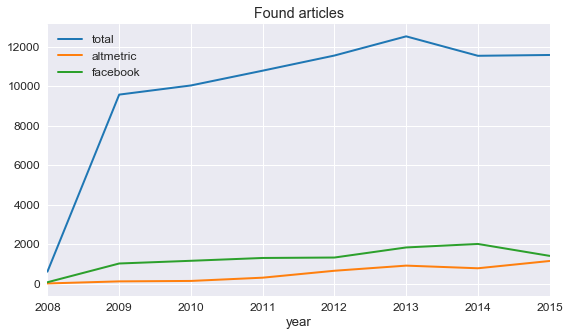

In [160]:
df.groupby(['year'])[['doi','am_posts', 'fb_shares']].count().plot();
plt.xlim([min_year, max_year]);
plt.gca().legend(labels=["total", "altmetric", "facebook"]);
plt.title("Found articles");

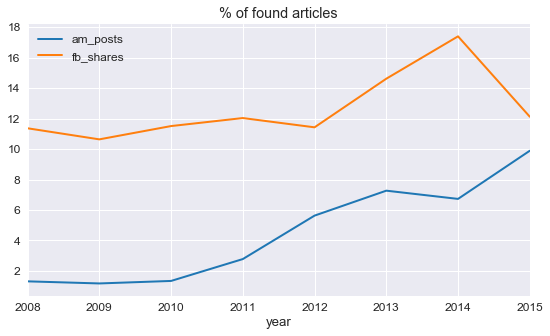

In [151]:
a = df.groupby(['year']).count()
(100*a[['am_posts', 'fb_shares']].divide(a.doi,0)).plot();
plt.title("% of found articles");

## Frequencies  across OA color

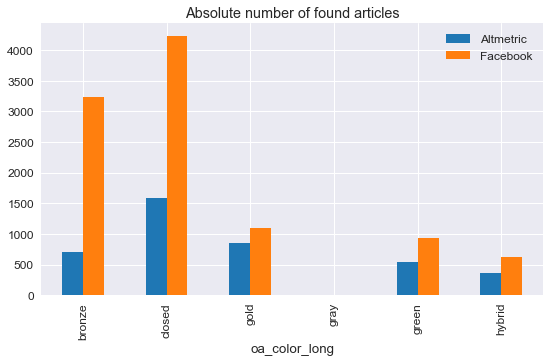

In [163]:
df.groupby(['oa_color_long'])[['am_posts', 'fb_shares']].count().plot(kind="bar");
plt.title("Absolute number of found articles")
plt.gca().legend(labels=["Altmetric", "Facebook"]);

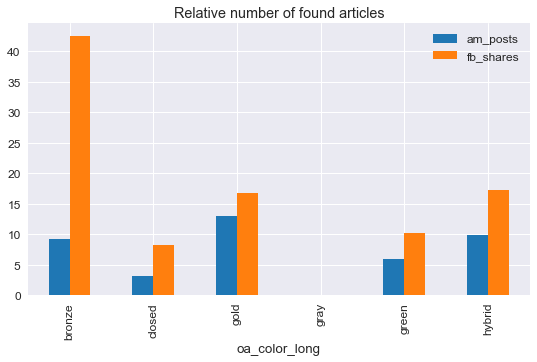

In [162]:
a = df.groupby(['oa_color_long']).count()
(100*a[['am_posts', 'fb_shares']].divide(a.doi,0)).plot(kind="bar");
plt.title("Relative number of found articles");

## Frequencies across years, OA colors

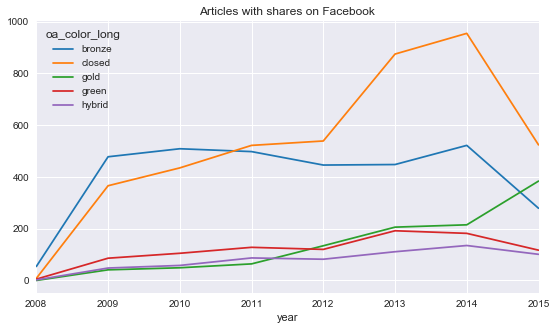

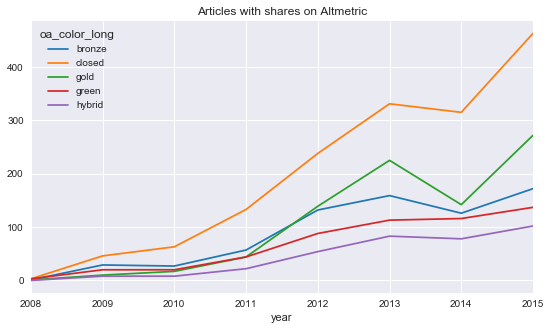

In [53]:
df.groupby(['year','oa_color_long'])['fb_shares'].count().unstack().plot()
plt.title("Articles with shares on Facebook");
df.groupby(['year','oa_color_long'])['am_posts'].count().unstack().plot()
plt.title("Articles with shares on Altmetric");

## Relative frequencies across years, OA colors

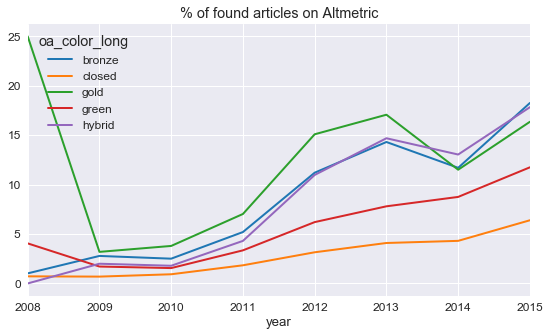

In [171]:
_ = pdf[pdf.platform=="am_posts"].groupby(["year", "oa_color_long"]).count()
a = _['shares']/_['doi']
(100*a).unstack().plot()
plt.title("% of found articles on Altmetric");

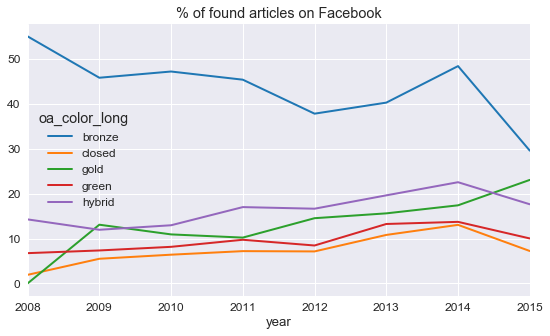

In [170]:
_ = pdf[pdf.platform=="fb_shares"].groupby(["year", "oa_color_long"]).count()
a = _['shares']/_['doi']
(100*a).unstack().plot();
plt.title("% of found articles on Facebook");

## Average shares across years

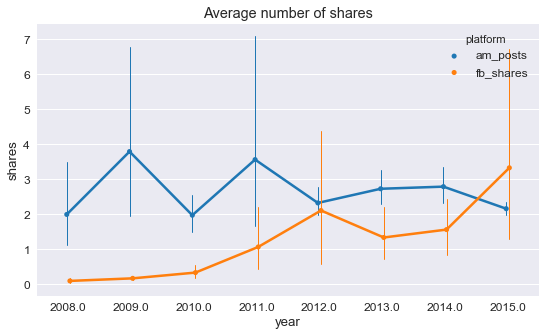

In [100]:
sns.pointplot(x="year", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");

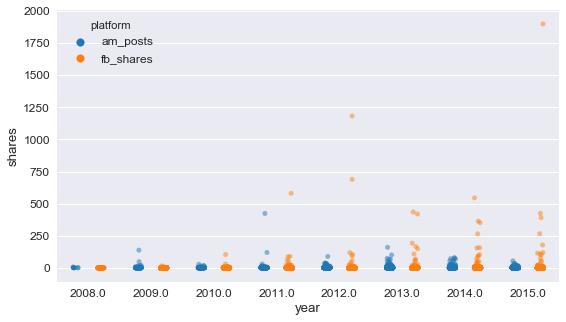

In [104]:
sns.stripplot(x="year", y="shares", hue="platform", data=pdf, jitter=True, dodge=True, alpha=.5);

## Average shares across OA colors

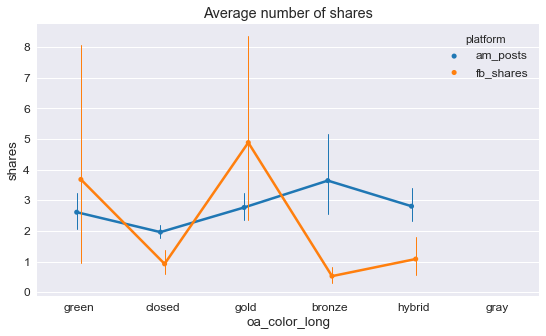

In [111]:
sns.pointplot(x="oa_color_long", y="shares", hue="platform", data=pdf,
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Average number of shares");

## Average shares across years and OA colors

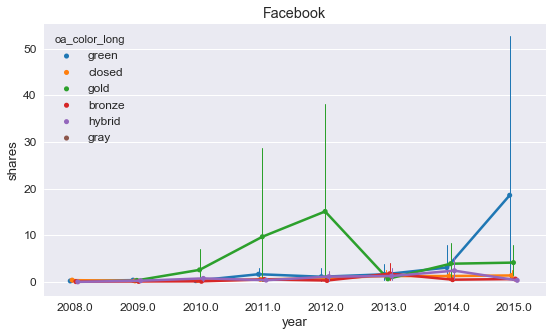

In [167]:
sns.pointplot(x="year", y="shares", hue="oa_color_long", data=pdf[pdf.platform == "fb_shares"],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Facebook");

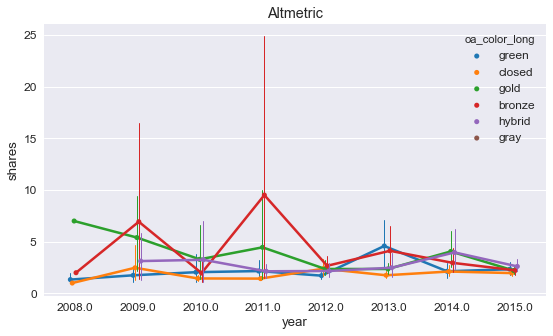

In [168]:
sns.pointplot(x="year", y="shares", hue="oa_color_long", data=pdf[pdf.platform == "am_posts"],
              estimator=np.mean,
              dodge=True, errwidth=1, markers=".", scale=0.7);
plt.title("Altmetric");

## Correlation

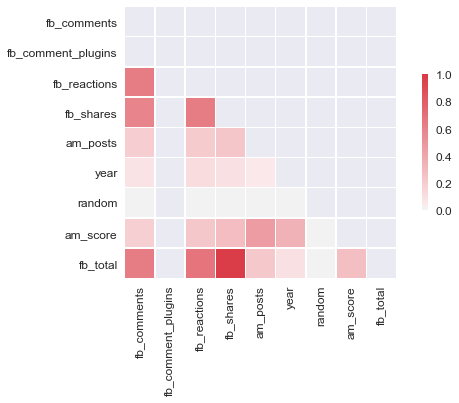

In [8]:
corr = df.corr(method = "spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})